In [53]:
#!pip install lightgbm
#!pip install --upgrade lightgbm
#!pip install category_encoders
#!pip install geopy
#!pip install imbalanced-learn

In [54]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import logging
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

In [55]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [56]:
data = pd.read_csv('final_dataset.csv')

In [57]:
columns_to_encode = ['merchant', 'category', 'season']

with open('label_encodings.txt', 'w') as file:
    for col in columns_to_encode:
        encoder = LabelEncoder()
        data[col + '_encoded'] = encoder.fit_transform(data[col])
        mappings = {index: label for index, label in enumerate(encoder.classes_)}
        file.write(f"{col} mappings:\n")
        for key, value in mappings.items():
            file.write(f"{key}: {value}\n")
        file.write("\n")

data.drop(columns=columns_to_encode, axis=1, inplace=True)

In [58]:
non_numeric_columns = data.select_dtypes(include=['object']).columns

print("Columnas no numéricas que podrían necesitar codificación:")
non_numeric_columns

Columnas no numéricas que podrían necesitar codificación:


Index(['trans_date_trans_time', 'trans_num', 'month_year', 'first_txn_time',
       'trans_date'],
      dtype='object')

In [59]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])  # Convertir la columna a datetime si no lo está.
data.set_index('trans_date_trans_time', inplace=True)  # Establecer esta columna como el índice del DataFrame.

# Ahora puedes agrupar por mes usando pd.Grouper
monthly_groups = data.groupby(pd.Grouper(freq='M'))
monthly_datasets = {}
for name, group in monthly_groups:
    print(f"Datos para el mes: {name}")
    monthly_datasets[name] = group
    print(group.head())
    print("\n-------------------------------------------\n")

Datos para el mes: 2019-01-31 00:00:00
                                 cc_num     amt      lat      long  \
trans_date_trans_time                                                
2019-01-01 00:00:18    2703186189652095    4.97  36.0788  -81.1781   
2019-01-01 00:00:44        630423337322  107.23  48.8878 -118.2105   
2019-01-01 00:00:51      38859492057661  220.11  42.1808 -112.2620   
2019-01-01 00:01:16    3534093764340240   45.00  46.2306 -112.1138   
2019-01-01 00:03:06     375534208663984   41.96  38.4207  -79.4629   

                                              trans_num   unix_time  \
trans_date_trans_time                                                 
2019-01-01 00:00:18    0b242abb623afc578575680df30655b9  1325376018   
2019-01-01 00:00:44    1f76529f8574734946361c461b024d99  1325376044   
2019-01-01 00:00:51    a1a22d70485983eac12b5b88dad1cf95  1325376051   
2019-01-01 00:01:16    6b849c168bdad6f867558c3793159a81  1325376076   
2019-01-01 00:03:06    a41d7549acf90789359a9

In [60]:
data.reset_index(inplace=True)

In [61]:
columns_to_remove = ['trans_date_trans_time', 'month_year', 'first_txn_time', 'trans_date', 'cc_num', 'trans_num', 'unix_time']
for month, dataset in monthly_datasets.items():
    # Eliminar columnas no deseadas que existen en el dataset
    existing_columns_to_remove = [col for col in columns_to_remove if col in dataset.columns]
    if existing_columns_to_remove:
        dataset.drop(columns=existing_columns_to_remove, inplace=True)

    # Convertir tipos de datos
    for col in dataset.columns:
        if dataset[col].dtype == 'object':  # Conversión de object a float si contiene solo números
            try:
                dataset[col] = dataset[col].astype(float)
            except ValueError:
                dataset[col] = dataset[col].astype('category')  # Convierte a categoría si no puede ser float

        elif dataset[col].dtype == 'bool':
            dataset[col] = dataset[col].astype(int)

    # Reasignar el dataset procesado al diccionario
    monthly_datasets[month] = dataset


C:\Users\marco\AppData\Local\Temp\ipykernel_96884\1669563455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns=existing_columns_to_remove, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_96884\1669563455.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[col] = dataset[col].astype(int)
C:\Users\marco\AppData\Local\Temp\ipykernel_96884\1669563455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [62]:
for month, dataset in monthly_datasets.items():
    for column in dataset.columns:
        if dataset[column].dtype == 'int64' or dataset[column].dtype == 'int32':
            dataset[column] = dataset[column].astype(float)
        elif dataset[column].dtype == 'bool':
            dataset[column] = dataset[column].astype(int)  # Convertir booleanos a enteros

    monthly_datasets[month] = dataset

for month, dataset in monthly_datasets.items():
    for column in dataset.columns:
        if dataset[column].dtype == 'int64' or dataset[column].dtype == 'int32':
            dataset[column] = dataset[column].astype(float)
        elif dataset[column].dtype == 'bool':
            dataset[column] = dataset[column].astype(int)  # Convertir booleanos a enteros

    monthly_datasets[month] = dataset

for month, dataset in monthly_datasets.items():
    for column in dataset.select_dtypes(include=['float64']).columns:
        dataset[column] = dataset[column].astype('float32').round(2)


C:\Users\marco\AppData\Local\Temp\ipykernel_96884\994440111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].astype(float)
C:\Users\marco\AppData\Local\Temp\ipykernel_96884\994440111.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].astype('float32').round(2)


In [63]:
# Revisar los tipos de datos de cada dataset mensual
for month, dataset in monthly_datasets.items():
    print(f"Tipos de datos para el mes: {month.strftime('%Y-%m')}")
    print(dataset.dtypes)  # Mostrar los tipos de datos
    print("\n-------------------------------------------\n")

Tipos de datos para el mes: 2019-01
amt                             float32
lat                             float32
long                            float32
merch_lat                       float32
merch_long                      float32
is_fraud                        float32
amt_month                       float32
amt_year                        float32
amt_month_shopping_net_spend    float32
count_month_shopping_net        float32
first_time_at_merchant          float32
time_since_last_txn             float32
avg_daily_amt                   float32
hour                            float32
avg_hourly_transactions         float32
prev_lat                        float32
prev_long                       float32
distance_from_last_txn          float32
monthly_spending_variation      float32
weekday                         float32
is_holiday                      float32
days_since_first_txn            float32
txn_count_last_24h              float32
avg_amt_last_24h                float32
std_

In [64]:
for month, dataset in monthly_datasets.items():
    null_counts = dataset.isnull().sum()
    dataset.fillna(0.0, inplace=True)
    monthly_datasets[month] = dataset

C:\Users\marco\AppData\Local\Temp\ipykernel_96884\533055138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_96884\533055138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_96884\533055138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.fillna(0.0, inplace=True)
C

In [65]:
# Diccionario para almacenar los datos de balance de fraude y conteo de valores nulos
fraud_balance = {}
null_counts = {}

# Recorrer cada grupo mensual
for name, group in monthly_datasets.items():
    print(f"Analizando el mes: {name.strftime('%Y-%m')}")

    # Contar frecuencias de la etiqueta 'is_fraud'
    fraud_count = group['is_fraud'].value_counts()
    fraud_balance[name] = fraud_count
    print("Distribución de fraudes:")
    print(fraud_count)

    # Contar valores nulos en el dataset
    null_count = group.isnull().sum()
    null_counts[name] = null_count
    print("Valores nulos por columna:")
    print(null_count)

    print("\n-------------------------------------------\n")

# Convertir los diccionarios a DataFrames para un resumen más estructurado
balance_summary = pd.DataFrame(fraud_balance).T.fillna(0)
null_summary = pd.DataFrame(null_counts).T.fillna(0)

print("Resumen de balance de 'is_fraud' por mes:")
print(balance_summary)
print("\nResumen de valores nulos por mes:")
print(null_summary)


Analizando el mes: 2019-01
Distribución de fraudes:
0.0    52019
1.0      506
Name: is_fraud, dtype: int64
Valores nulos por columna:
amt                             0
lat                             0
long                            0
merch_lat                       0
merch_long                      0
is_fraud                        0
amt_month                       0
amt_year                        0
amt_month_shopping_net_spend    0
count_month_shopping_net        0
first_time_at_merchant          0
time_since_last_txn             0
avg_daily_amt                   0
hour                            0
avg_hourly_transactions         0
prev_lat                        0
prev_long                       0
distance_from_last_txn          0
monthly_spending_variation      0
weekday                         0
is_holiday                      0
days_since_first_txn            0
txn_count_last_24h              0
avg_amt_last_24h                0
std_amt_last_24h                0
online_txn_ratio

Rebalancear los datos mensuales con SOMET

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

# Diccionario para almacenar los datasets equilibrados
resampled_datasets = {}

for name, month_data in monthly_datasets.items():
    print(f"Aplicando SMOTE para: {name.strftime('%Y-%m')}")

    # Hacer una copia explícita para evitar SettingWithCopyWarning
    month_data = month_data.copy()

    # Tratar valores infinitos y NaN
    month_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    month_data.fillna(month_data.median(), inplace=True)

    # Escalado de características para evitar valores extremadamente grandes
    scaler = MinMaxScaler()  # o StandardScaler() si prefieres normalización estándar
    features = month_data.drop(['is_fraud'], axis=1)
    scaled_features = scaler.fit_transform(features)
    X = pd.DataFrame(scaled_features, columns=features.columns)
    y = month_data['is_fraud']

    # Aplicar SMOTE con una proporción específica
    smote = SMOTE(random_state=42, sampling_strategy=0.33)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Crear un nuevo DataFrame con los datos equilibrados
    resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
    resampled_data['is_fraud'] = y_resampled

    # Almacenar el conjunto de datos resampleado
    resampled_datasets[name] = resampled_data

    # Imprimir la nueva distribución de clases
    balance = y_resampled.value_counts()


Aplicando SMOTE para: 2019-01
Aplicando SMOTE para: 2019-02
Aplicando SMOTE para: 2019-03
Aplicando SMOTE para: 2019-04
Aplicando SMOTE para: 2019-05
Aplicando SMOTE para: 2019-06
Aplicando SMOTE para: 2019-07
Aplicando SMOTE para: 2019-08
Aplicando SMOTE para: 2019-09
Aplicando SMOTE para: 2019-10
Aplicando SMOTE para: 2019-11
Aplicando SMOTE para: 2019-12
Aplicando SMOTE para: 2020-01
Aplicando SMOTE para: 2020-02
Aplicando SMOTE para: 2020-03
Aplicando SMOTE para: 2020-04
Aplicando SMOTE para: 2020-05
Aplicando SMOTE para: 2020-06
Aplicando SMOTE para: 2020-07
Aplicando SMOTE para: 2020-08
Aplicando SMOTE para: 2020-09
Aplicando SMOTE para: 2020-10
Aplicando SMOTE para: 2020-11
Aplicando SMOTE para: 2020-12


In [67]:
# Seleccionar un mes específico para la muestra, por ejemplo, enero de 2019
sample_month = pd.Timestamp('2019-01-31')

# Acceder al dataset resampleado para ese mes
sample_data = resampled_datasets[sample_month]

# Mostrar las primeras filas del DataFrame resampleado
print(sample_data.head())

# Mostrar los tipos de datos para asegurarnos de que son adecuados
print("\nTipos de datos en el DataFrame resampleado:")
print(sample_data.dtypes)

        amt       lat      long  merch_lat  merch_long  amt_month  amt_year  \
0  0.000334  0.351511  0.864613   0.356363    0.848746   0.000260  0.000260   
1  0.008949  0.632063  0.485673   0.632507    0.486259   0.007011  0.007011   
2  0.018457  0.485107  0.546561   0.506300    0.546841   0.014463  0.014463   
3  0.003706  0.573806  0.548097   0.587778    0.542728   0.002903  0.002903   
4  0.003450  0.402759  0.882214   0.412432    0.883049   0.002702  0.002702   

   amt_month_shopping_net_spend  count_month_shopping_net  \
0                           0.0                       0.0   
1                           0.0                       0.0   
2                           0.0                       0.0   
3                           0.0                       0.0   
4                           0.0                       0.0   

   first_time_at_merchant  ...  transaction_speed  amt_to_daily_avg  \
0                     1.0  ...                0.0          0.000129   
1               

In [68]:
monthly_datasets = resampled_datasets

Vamos a ver el balance de los datos en graficos

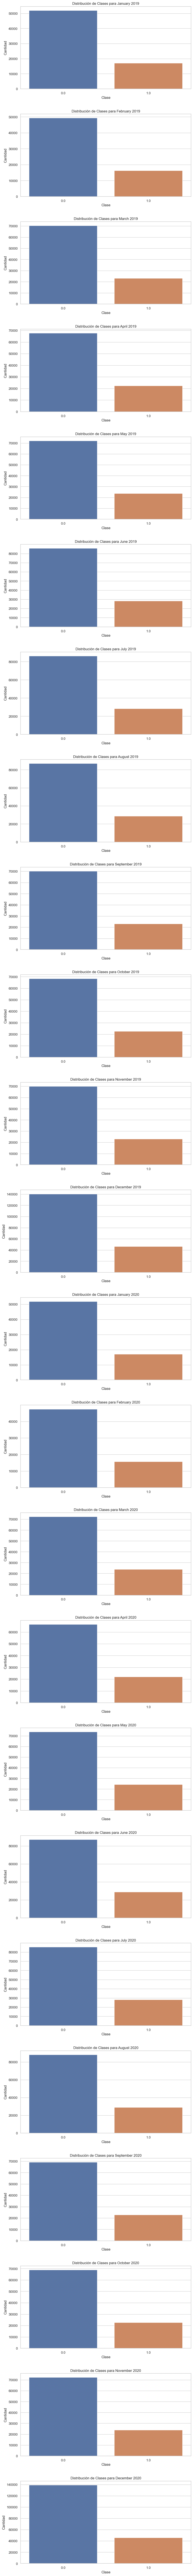

In [69]:
sns.set(style="whitegrid")  # Establece el estilo de los gráficos con seaborn

# Crear una figura para contener los subgráficos
fig, axes = plt.subplots(nrows=len(monthly_datasets), ncols=1, figsize=(10, 5 * len(monthly_datasets)))
fig.tight_layout(pad=5.0)  # Ajusta el layout para evitar la superposición

# Iterar a través de cada conjunto de datos mensual
for ax, (month, data) in zip(axes, monthly_datasets.items()):
    # Contar las instancias de cada clase
    class_counts = data['is_fraud'].value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax)
    ax.set_title(f'Distribución de Clases para {month.strftime("%B %Y")}')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')

plt.show()


Podemos ver que ahora nuestro set de datos esta balanceado a una proporción de 1 fraude por cada X transacciones. Procedemos a guardar los datasets.

In [70]:
# Directorio para guardar los archivos CSV
output_dir = 'final_datasets'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardar cada dataset en un archivo CSV
for name, dataset in resampled_datasets.items():
    file_path = os.path.join(output_dir, f'resampled_data_{name.strftime("%Y_%m")}.csv')
    dataset.to_csv(file_path, index=False)
    print(f"Dataset para {name.strftime('%Y-%m')} guardado en: {file_path}")


Dataset para 2019-01 guardado en: final_datasets\resampled_data_2019_01.csv
Dataset para 2019-02 guardado en: final_datasets\resampled_data_2019_02.csv
Dataset para 2019-03 guardado en: final_datasets\resampled_data_2019_03.csv
Dataset para 2019-04 guardado en: final_datasets\resampled_data_2019_04.csv
Dataset para 2019-05 guardado en: final_datasets\resampled_data_2019_05.csv
Dataset para 2019-06 guardado en: final_datasets\resampled_data_2019_06.csv
Dataset para 2019-07 guardado en: final_datasets\resampled_data_2019_07.csv
Dataset para 2019-08 guardado en: final_datasets\resampled_data_2019_08.csv
Dataset para 2019-09 guardado en: final_datasets\resampled_data_2019_09.csv
Dataset para 2019-10 guardado en: final_datasets\resampled_data_2019_10.csv
Dataset para 2019-11 guardado en: final_datasets\resampled_data_2019_11.csv
Dataset para 2019-12 guardado en: final_datasets\resampled_data_2019_12.csv
Dataset para 2020-01 guardado en: final_datasets\resampled_data_2020_01.csv
Dataset para